In [2]:
import os
# Suppress TensorFlow C++ backend logs:
#   '0' = all logs shown
#   '1' = hide INFO messages
#   '2' = hide INFO & WARNING messages
#   '3' = hide INFO, WARNING, and only show ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
# Suppress Python warnings (e.g., DeprecationWarnings, UserWarnings)
warnings.filterwarnings('ignore')

import tensorflow as tf
# Suppress TensorFlow Python-level logs as well (only show ERROR)
tf.get_logger().setLevel('ERROR')

In [3]:
import os
import csv
import pandas as pd
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# ==============================
# === LIST OF BBH EVENTS ===
# ==============================
# A collection of confirmed binary black hole (BBH) merger events
# taken from LIGO/Virgo public GWOSC catalog
bbh_events = [
    'GW150914','GW151012','GW151226','GW170104','GW170608','GW170729',
    'GW170809','GW170814','GW170818','GW170823','GW190408_181802',
    'GW190412','GW190413_052954','GW190413_134308','GW190421_213856',
    'GW190424_180648','GW190425','GW190503_185404','GW190512_180714',
    'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544',
    'GW190521','GW190521_074359','GW190527_092055','GW190602_175927',
    'GW190620_030421','GW190630_185205','GW190701_203306','GW190706_222641',
    'GW190707_093326','GW190708_232457','GW190719_215514','GW190720_000836',
    'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701',
    'GW190814','GW190828_063405','GW190828_065509','GW190909_114149',
    'GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',
    'GW190930_133541'
]

# ==============================
# === OUTPUT DIRECTORY ===
# ==============================
output_dir = "./BBH/original-signals/"
# merged_csv = "./BBH/Original_BBH.csv"  # (Optional) Path for saving merged CSV
os.makedirs(output_dir, exist_ok=True)


# ==============================
# === FETCH AND SAVE DATA ===
# ==============================
# For each BBH event:
#   1. Get the GPS time from GWOSC
#   2. Extract a 30-second window of strain data (15s before + 15s after event)
#   3. Save data as a text file
for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])          # Get GPS time of the event
    start = int(gps) - 15                   # 15 seconds before event
    end = int(gps) + 15                     # 15 seconds after event

    # Fetch strain time series from L1 detector
    data = TimeSeries.fetch_open_data('L1', start, end)
    # Save strain data as a text file named after the event
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [04:07<00:00,  5.16s/it]


In [4]:
input_dir = "./BBH/original-signals/"   # Directory with raw GW strain data (30s windows)
output_dir = "./BBH/processed-signals/" # Directory to save preprocessed signals
os.makedirs(output_dir, exist_ok=True)  

# ========================================
# === PROCESS EACH BBH EVENT TIME SERIES ===
# ========================================
for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])  # Get GPS time of the event
    # --- Load raw strain data for the event ---
    data = TimeSeries.read(input_dir + bbh_events[i]+".txt")
    # --- Preprocessing steps ---
    # 1. Whiten the data using 4s FFT segments and 2s overlap
    data = data.whiten(4,2)
    # 2. Apply bandpass filter to keep frequencies in 35–350 Hz range
    data = data.bandpass(35, 350) 
    # 3. Crop around the merger event (±2s window around GPS time)
    data = data.crop(gps - 2, gps + 2)
    # 4. Apply a Tukey taper to smooth edges (avoid FFT artifacts)
    data = data.taper('leftright', 0.5)
    # 5. Rescale amplitude (convert to physical strain units ~1e-21 scale)
    data = data * 1e-21
    # --- Save processed strain data ---
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [00:08<00:00,  5.96it/s]


In [5]:
path = "./BBH/processed-signals/"   # Directory containing processed BBH signal .txt files
files = os.listdir(path)            # List of all files in directory

# Open CSV file for writing merged output
path = "./BBH/processed-signals/"
files= os.listdir(path)
f = open("./BBH/processed.csv", 'w')
cw = csv.writer(f)
# ========================================
# === MERGE ALL SIGNAL FILES INTO CSV ===
# ========================================  
for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:01<00:00, 46.31it/s]


In [8]:
import os
import numpy as np
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# ========================================
# PARAMETERS
# ========================================
start, end = 1238166018, 1253977218   # GPS start and end times for O3a run
detector = 'L1'                       # Detector: 'H1', 'L1', or 'V1'
segment_duration = 30                 # Initial segment duration for download (seconds)
crop_duration = 4                     # Final cropped segment length (seconds)
sample_rate = 4096                    # Sampling frequency (Hz)
n_segments = 48                       # Total number of unseen noise segments to save

# Output directory for unseen noise files
output_dir = "./BBH/original-noise-unseen/"
os.makedirs(output_dir, exist_ok=True)

# ========================================
# SELECT RANDOM START TIMES
# ========================================
np.random.seed(123)  # Fix seed for reproducibility
# Generate candidate random start times inside O3a run
# (5× more candidates than needed, since some may fail)
start_times = np.random.randint(start, end - segment_duration, size=n_segments * 5)

# ========================================
# DOWNLOAD AND PREPROCESS NOISE SEGMENTS
# ========================================
downloaded = 0  # Counter for successfully saved segments

for gps_start in tqdm(start_times, desc="Downloading unseen noise"):
    if downloaded >= n_segments:
        break # Stop when desired number of files is reached
    try:
        # --- Step 1: Fetch 30-second raw strain data ---
        ts = TimeSeries.fetch_open_data(detector, gps_start, gps_start + segment_duration, sample_rate=sample_rate)
        # --- Step 2: Apply bandpass filter (keep 35–350 Hz, where LIGO is sensitive) ---
        ts = ts.bandpass(35, 350)
        # --- Step 3: Crop 4-second window centered in the 30-second segment ---
        gps_center = gps_start + segment_duration // 2
        ts = ts.detrend('linear')
        ts = ts.crop(gps_center - crop_duration // 2, gps_center + crop_duration // 2)
        # --- Step 4: Apply tapering to smooth edges (reduce spectral leakage) ---
        ts = ts.taper('leftright', 0.5)
        # --- Step 5: Check validity (must have exact number of samples) ---
        if len(ts) != sample_rate * crop_duration:
            continue # Skip invalid/corrupted segment
        # --- Step 6: Save final 4-second segment to file ---
        ts.write(os.path.join(output_dir, f"noise_{downloaded}.txt"))
        downloaded += 1
    except Exception as e:
        # Skip if download or processing fails (e.g., missing data)
        continue

In [9]:
import csv
import pandas as pd

# ========================================
# PATHS
# ========================================
path = "./BBH/original-noise-unseen/"
files= os.listdir(path)
# Open CSV file for writing all unseen noise segments
f = open("./BBH/original-noise-unseen.csv", 'w')
cw = csv.writer(f)

# ========================================
# MERGE ALL NOISE FILES INTO ONE CSV
# ========================================
for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:01<00:00, 44.75it/s]


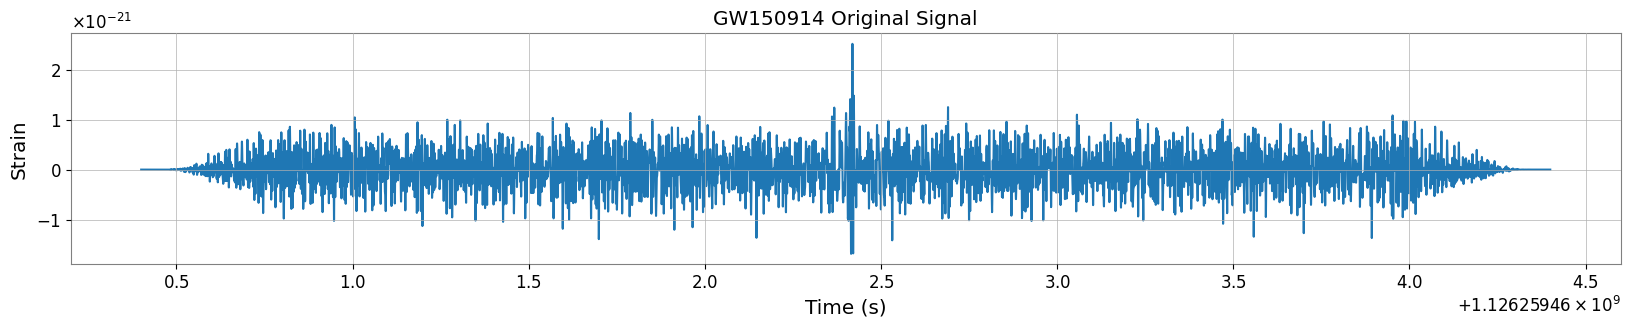

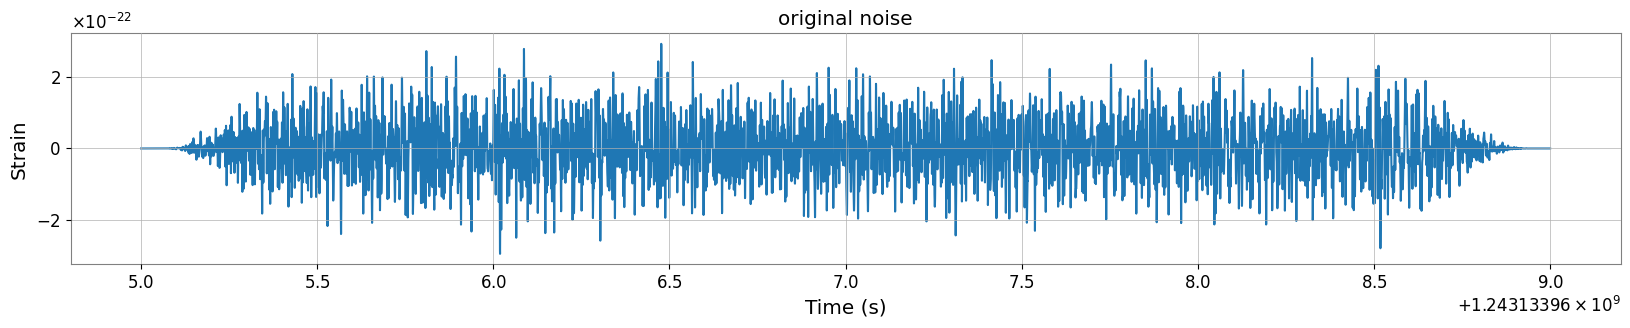

In [10]:
from gwpy.timeseries import TimeSeries as GTimeSeries
import matplotlib.pyplot as plt

# ========================================
# PLOT A PROCESSED GW EVENT SIGNAL
# ========================================
# Load processed strain data for GW150914 (after whitening, bandpass, crop, etc.)
ts = GTimeSeries.read('./BBH/processed-signals/GW150914.txt')
# Plot time series
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("GW150914 Original Signal")   # Title = event name
plt.xlabel("Time (s)")                  # x-axis: time in seconds
plt.ylabel("Strain")                    # y-axis: strain amplitude
plt.grid(True)                          # add grid for readability
plt.show()

# ========================================
# PLOT AN UNSEEN NOISE SEGMENT
# ========================================
# Load one unseen noise sample (from O3a run)
ts = GTimeSeries.read('./BBH/original-noise-unseen/noise_0.txt')
# Plot time series
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("original noise") # Title = unseen noise
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()